In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
import copy

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import savemat
import scipy.signal

import torch
import torchvision
import torchvision.transforms as transforms

import os

# for reading and displaying images
from skimage.io import imread
# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score

import pathlib
from imgaug import augmenters as iaa


%matplotlib notebook
%matplotlib notebook
%matplotlib inline
# %matplotlib qt

In [3]:
torch.cuda.current_device()

0

In [4]:
torch.cuda.get_device_name(0)

'GeForce RTX 3090'

Load and preprocess stat file and labels  
Labels must be made in the 'ROI_labeling_and_augmentation' script and the relabeling script  
## outputs: 'images' and 'labels' (both input into CNN)


PATH:   /media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/old_stuff/label data/mouse 6_28 _ day 20200903/stat.npy

stat file loaded

Number of ROIs: 4868


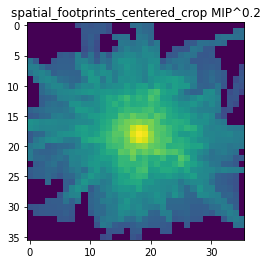

In [5]:
# LOAD stat.npy file 1
#___________________


# dir_load = '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20200815\\suite2p\\plane0\\'
fileName_load = 'stat.npy'

PATH_absolute = pathlib.Path('.').absolute()
PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse 6_28 _ day 20200903/'
# PATH_load_dir_statFile = '/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/test data_mouse6_28 _ 20200815/'
print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
print('')

stat = np.load(f'{PATH_load_dir_statFile}{fileName_load}', allow_pickle=True)
print('stat file loaded')
print('')

num_ROI = stat.shape[0]
print(f'Number of ROIs: {num_ROI}')

height = 512
width = 1024
spatial_footprints_centered = np.zeros((num_ROI, 241,241))
for i in range(num_ROI):
    spatial_footprints_centered[i , stat[i]['ypix'] - np.int16(stat[i]['med'][0]) + 120, stat[i]['xpix'] - np.int16(stat[i]['med'][1]) + 120] = stat[i]['lam'] # this is formatted for coding ease (dim1: y pix) (dim2: x pix) (dim3: ROI#)
spatial_footprints_centered_crop = spatial_footprints_centered[:, 102:138 , 102:138]

# %matplotlib inline
plt.figure()
plt.imshow(np.max(spatial_footprints_centered_crop , axis=0) ** 0.2);
plt.title('spatial_footprints_centered_crop MIP^0.2');

images = spatial_footprints_centered_crop

PATH:   /media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/old_stuff/label data/mouse6_28 _ day20200815/stat.npy

stat file loaded

Number of ROIs: 4847


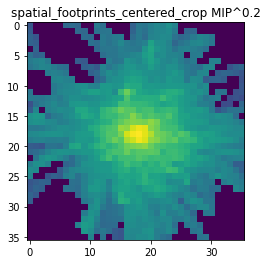

In [6]:
# LOAD stat.npy file 2
#___________________


# dir_load = '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20200815\\suite2p\\plane0\\'
fileName_load = 'stat.npy'

PATH_absolute = pathlib.Path('.').absolute()
# PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse 6_28 _ day 20200903/'
PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse6_28 _ day20200815/'
# PATH_load_dir_statFile = '/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/test data_mouse6_28 _ 20200815/'
print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
print('')

stat2 = np.load(f'{PATH_load_dir_statFile}{fileName_load}', allow_pickle=True)
print('stat file loaded')
print('')

num_ROI2 = stat2.shape[0]
print(f'Number of ROIs: {num_ROI2}')

height = 512
width = 1024
spatial_footprints_centered2 = np.zeros((num_ROI2, 241,241))
for i in range(num_ROI2):
    spatial_footprints_centered2[i , stat2[i]['ypix'] - np.int16(stat2[i]['med'][0]) + 120, stat2[i]['xpix'] - np.int16(stat2[i]['med'][1]) + 120] = stat2[i]['lam'] # this is formatted for coding ease (dim1: y pix) (dim2: x pix) (dim3: ROI#)
spatial_footprints_centered_crop2 = spatial_footprints_centered2[:, 102:138 , 102:138]

# %matplotlib inline
plt.figure()
plt.imshow(np.max(spatial_footprints_centered_crop2 , axis=0) ** 0.2);
plt.title('spatial_footprints_centered_crop MIP^0.2');

# images = spatial_footprints_centered_crop

In [7]:
images = np.concatenate((spatial_footprints_centered_crop , spatial_footprints_centered_crop2) , axis = 0)
print(images.shape)

(9715, 36, 36)


PATH:   /media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/old_stuff/label data/mouse 6_28 _ day 20200903/labels_posthoc_filledIn_allCells.npy

labels file loaded



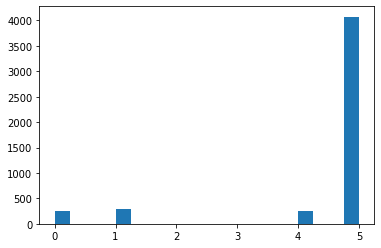

In [8]:
# LOAD labels file 1
#___________________

num_labels = 6

PATH_absolute = pathlib.Path('.').absolute()
PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse 6_28 _ day 20200903/'
fileName_load = 'labels_posthoc_filledIn_allCells.npy'
print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
print('')

labels1 = np.load(f'{PATH_load_dir_statFile}{fileName_load}')
print('labels file loaded')
print('')


plt.figure()
# plt.hist(labels,20);
plt.hist(labels1,20);


#check in number of labels matches number of images
if images.shape[0] == len(labels1):
    print('number of labels and images match')
else:
    print('WARNING: number of labels and images DO NOT match')


PATH:   /media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/old_stuff/label data/mouse6_28 _ day20200815/labels_posthoc_all.npy

labels file loaded



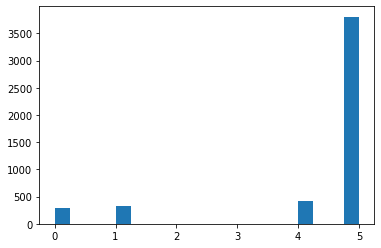

In [9]:
# LOAD labels file 2
#___________________

num_labels = 6

PATH_absolute = pathlib.Path('.').absolute()
PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse6_28 _ day20200815/'
fileName_load = 'labels_posthoc_all.npy'
print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
print('')

labels2 = np.load(f'{PATH_load_dir_statFile}{fileName_load}')
print('labels file loaded')
print('')


plt.figure()
# plt.hist(labels,20);
plt.hist(labels2,20);


#check in number of labels matches number of images
if images.shape[0] == len(labels2):
    print('number of labels and images match')
else:
    print('WARNING: number of labels and images DO NOT match')

In [10]:
labels = np.concatenate((labels1 , labels2))
print(labels.shape)

(9715,)


In [11]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(images[:], labels[:], test_size = 0.15)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((8257, 36, 36), (8257,)), ((1458, 36, 36), (1458,)))

In [12]:
# importing the libraries
import pandas as pd

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Sigmoid, SELU, GELU, ELU, PReLU, Softplus, Softmax2d, AvgPool2d, Tanh
from torch.optim import Adam, SGD

counts = np.histogram(labels,np.arange(7))

weightings_groups_forSampling = np.zeros(6)
for ii in np.array([0,1,4,5]):
    weightings_groups_forSampling[ii] = np.max(counts[0]) / counts[0][ii]

plt.figure()
plt.bar(range(6), weightings_groups_forSampling)

# %matplotlib qt
weightings_forSampling = np.zeros(len(labels)) + 1e-9
for ii in range(len(weightings_forSampling)):
    weightings_forSampling[ii] = weightings_groups_forSampling[labels[ii]]

weightings_forSampling = weightings_forSampling / np.sum(weightings_forSampling)
plt.figure()
plt.plot(weightings_forSampling)
plt.plot(scipy.signal.savgol_filter(weightings_forSampling,11,2))

# light data augmentation
duplicates = 10

# duplication to equalize the probability of encountering each case

images_dup = train_x[0][None,:,:]
labels_aug = np.array([val_y[0]])

for ii in range(6):
    images_dup = np.concatenate( ( images_dup , np.tile(images[labels==ii] ,( np.int16(weightings_groups_forSampling[ii]) , 1 , 1 ) )), axis=0)
    labels_aug = np.concatenate( ( labels_aug , np.ones( np.int16(weightings_groups_forSampling[ii]) * np.sum(labels==ii) ) * ii) )
images_dup = np.tile(images_dup , (duplicates,1,1))
# images_dup = images_dup / np.tile(np.max(images_dup , axis=(1,2)) , (images_dup.shape[1], images_dup.shape[2], 1)).transpose(2,0,1) # noramlized all the images' max values to 1
labels_aug = np.tile(labels_aug , duplicates)

test = np.ones(images_dup.shape[0]) * np.nan
images_dup_int8 = np.int8(np.zeros_like(images_dup))
images_dup_uint8 = np.uint8(np.zeros_like(images_dup))
for ii , val in enumerate(images_dup):
    images_dup_int8[ii] = np.int8(np.round((( images_dup[ii] / np.max(images_dup[ii], axis=(0,1)) ) -0.5) * 122))
    images_dup_uint8[ii] = np.uint8(np.round((( images_dup[ii] / np.max(images_dup[ii], axis=(0,1)) )) * 122))
    test[ii] = np.mean(images_dup_uint8[ii], axis=(0,1))

In [13]:
duplicates = 3

images_dup = np.tile(train_x , (duplicates , 1 , 1))
labels_aug = np.tile(train_y , (duplicates))

print(images_dup.shape)
print(labels_aug.shape)

numToGetTo = np.sum(labels_aug==0)
print(numToGetTo)
for ii in np.array([1,4,5]):
#     idxToDelete = np.cumsum(labels_aug==ii) <= (np.sum(labels_aug==ii) - numToGetTo)
    if ii==5:
        numToGetTo = np.sum(labels_aug==0)/2
    else:
        numToGetTo = np.sum(labels_aug==0)

    idxToDelete = (np.cumsum(labels_aug==ii) * (labels_aug==ii)) > numToGetTo
    images_dup = images_dup[idxToDelete==0,:,:]
    labels_aug = labels_aug[idxToDelete==0]


print(np.sum(labels_aug==0))
print(np.sum(labels_aug==1))
print(np.sum(labels_aug==4))
print(np.sum(labels_aug==5))
print(images_dup.shape)
print(labels_aug.shape)

(24771, 36, 36)
(24771,)
1392
1392
1392
1392
696
(4872, 36, 36)
(4872,)


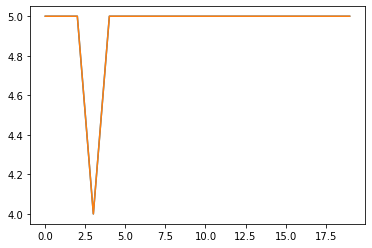

In [14]:
# %matplotlib inline
# %matplotlib inline

plt.figure()
plt.plot(labels_aug[:20])
plt.plot(train_y[:20])
# plt.plot(scipy.signal.savgol_filter(labels_aug , 11 , 3))

# plt.figure()
# plt.imshow(images_dup[5]);
# print(images_dup.dtype)

In [15]:
aug_seq = iaa.Sequential([
    iaa.Fliplr(0.5), # flips
    iaa.Fliplr(0.5), # flips
#     # Small gaussian blur with random sigma between 0 and 0.5.
#     # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.3,
#         iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.7, 1.4), "y": (0.7, 1.4)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-180, 180),
        shear=(-25, 25)
    ),
    # Sharpen each image, overlay the result with the original
    # image using an alpha between 0 (no sharpening) and 1
    # (full sharpening effect).
#     iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
#     iaa.PiecewiseAffine(scale=0.02, nb_cols=6, nb_rows=6),  # very slow
    
    
], random_order=True) # apply augmenters in random order

np.save('images_aug.npy' , images_aug)

images_aug = np.load('images_aug.npy')

(4872, 36, 36)
float64
float64


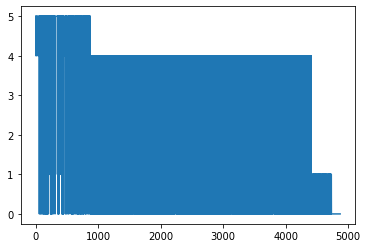

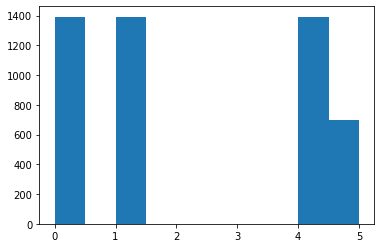

In [16]:
# images_aug = aug_seq(images=images_dup_uint8)
images_aug = aug_seq(images=images_dup)
# images_aug = images_dup
# images_aug = images_aug

# images_aug = images_aug / np.tile(np.max(images_aug , axis=(1,2)) , (images_aug.shape[1], images_aug.shape[2], 1)).transpose(2,0,1) # noramlized all the images' max values to 1

print(images_aug.shape)

# plt.figure()
# plt.imshow(images_dup_uint8[6])
plt.figure()
plt.plot(labels_aug)
plt.figure()
plt.hist(labels_aug);

print(images_dup.dtype)
print(images_aug.dtype)

# print(images_aug.shape)
# print(labels_aug.shape)

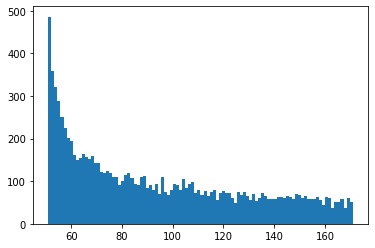

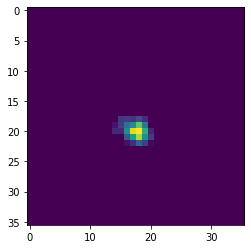

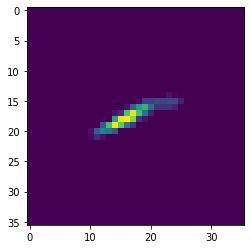

In [17]:
# noiseGain_inverse = np.random.rand(1)**2 * 100 + 10
# plt.figure()
# test = (100 * ( np.random.rand(10000) + 0.1 )**2)+12
# plt.hist(test[test < 1000],100);
noiseGain_inverse = lambda x: (100 * ( np.random.rand(x) + 0.1 )**2)+50
plt.figure()
plt.hist(noiseGain_inverse(10000),100)

images_toUse = images_aug

images_aug_noisy = np.zeros_like(images_toUse)
for ii in range(images_toUse.shape[0]):
    if np.random.rand(1) < 0.8:
        noise = noiseGain_inverse(1)
#         images_aug_noisy[ii] = np.random.poisson(images_toUse[ii] / np.max(images_toUse[ii]) ) * noise / noise * np.max(images_toUse[ii])   # noisy image
        images_aug_noisy[ii] = np.random.poisson(images_toUse[ii] / np.max(images_toUse[ii]) * noise) / noise * np.max(images_toUse[ii])   # noisy image
    else:
        images_aug_noisy[ii] = images_toUse[ii]
plt.figure()
plt.imshow(images_aug_noisy[0])
plt.figure()
plt.imshow(images_aug_noisy[1])

np.save('images_aug.npy' , images_aug)

<IPython.core.display.Javascript object>


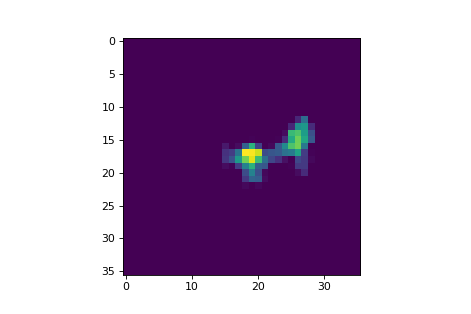

1.0407583689407367


In [18]:
%matplotlib notebook
plt.figure()
plt.imshow(images_aug_noisy[8])
print(np.sum(images_aug_noisy[8]))

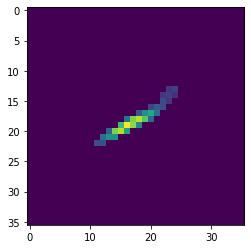

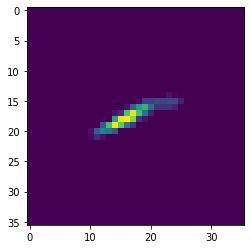

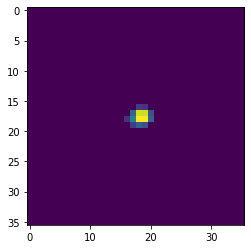

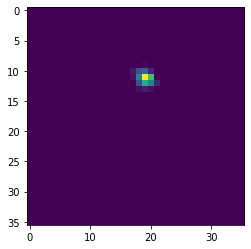

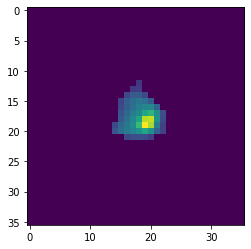

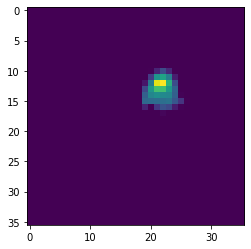

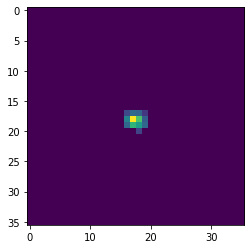

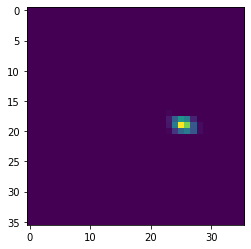

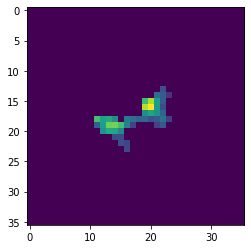

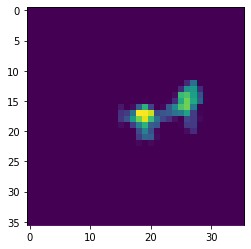

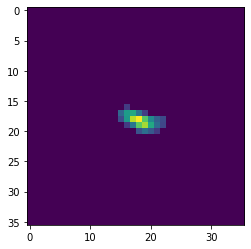

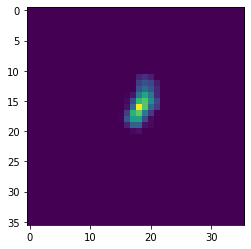

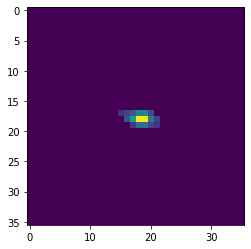

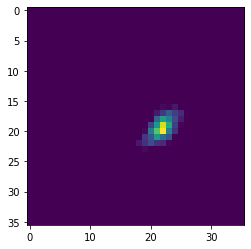

In [19]:
%matplotlib inline
plt.figure()
plt.imshow(images_dup[1])
plt.figure()
plt.imshow(images_aug_noisy[1])
plt.figure()
plt.imshow(images_dup[5])
plt.figure()
plt.imshow(images_aug_noisy[5])
plt.figure()
plt.imshow(images_dup[6])
plt.figure()
plt.imshow(images_aug_noisy[6])
plt.figure()
plt.imshow(images_dup[7])
plt.figure()
plt.imshow(images_aug_noisy[7])
plt.figure()
plt.imshow(images_dup[8])
plt.figure()
plt.imshow(images_aug_noisy[8])
plt.figure()
plt.imshow(images_dup[9])
plt.figure()
plt.imshow(images_aug_noisy[9])
plt.figure()
plt.imshow(images_dup[10])
plt.figure()
plt.imshow(images_aug_noisy[10])

0.40469717569116703
0.0
5
0
torch.Size([4872, 1, 36, 36])
torch.Size([4872])


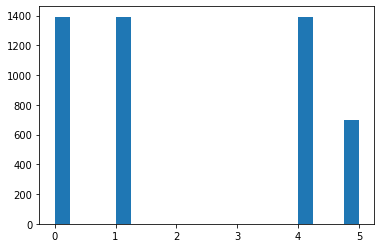

In [20]:
images_toUse = copy.deepcopy(images_aug)

# normalize
for ii in range(images_toUse.shape[0]):
    images_toUse[ii] = images_toUse[ii] / np.sum(images_toUse[ii])

# %matplotlib inline
# data_y = copy.deepcopy(labels[:643])
# data_y = np.int16(data_y - 1)

# data_y = train_y
# data_y = copy.deepcopy(labels_posthoc_filledIn)
data_y = copy.deepcopy(labels_aug)
# data_y = labels
# data_y = copy.deepcopy(train_y)

# data_x = images[:643,:,:]
# data_x = images
# data_x = train_x
# data_x = images_aug
# data_x = images_aug_noisy
data_x = images_toUse
# data_x = images_dup
# data_x = data_x / np.max(np.max(data_x, axis=2) , axis=1)[:,None,None]


# sample_submission = pd.read_csv('sample_submission_I5njJSF.csv')

# train.head()

print(np.max(data_x))
print(np.min(data_x))
print(np.max(data_y))
print(np.min(data_y))
# plt.figure()
# plt.imshow(np.squeeze(data_y[3,:,:,:]))
# data_y
plt.figure()
plt.hist(data_y,20);

# converting training images into torch format
data_x = data_x[:,None,:,:]
# train_x  = torch.from_numpy(train_x)
data_x = torch.as_tensor(data_x).type('torch.cuda.FloatTensor')

# converting the target into torch format
data_y = data_y.astype(int);
# train_y = torch.from_numpy(train_y)
data_y = torch.as_tensor(data_y).type('torch.cuda.LongTensor')

# shape of training data
print(data_x.shape)
print(data_y.shape)

In [21]:
data_x.shape

torch.Size([4872, 1, 36, 36])

In [22]:
heldOut_x = torch.as_tensor(val_x[: , None , : , :]).type('torch.cuda.FloatTensor')
heldOut_y = torch.as_tensor(val_y.astype(int)).type('torch.cuda.LongTensor')
print(heldOut_x.shape)
print(heldOut_y.shape)

torch.Size([1458, 1, 36, 36])
torch.Size([1458])


In [23]:
# # check heldOut labels just to be sure

# %matplotlib qt
# fig = plt.figure()
# tmp = ''
# ii = np.random.randint(0,heldOut_x.shape[0])
# while not tmp:
#     ii = np.random.randint(0,heldOut_x.shape[0])
#     plt.imshow(heldOut_x[ii,0])
#     plt.title(heldOut_y[ii])
#     plt.pause(0.1)
#     tmp = input()
# #     ii= ii+1
#     print(ii)

In [24]:
# dropout_prob = 0.3
# momentum_val = 0.9

# class Net(Module):   
#     def __init__(self):
#         super(Net, self).__init__()

#         self.cnn_layers = Sequential(
#             # Defining a 2D convolution layer
#             BatchNorm2d(1, momentum=momentum_val),
#             Conv2d(1, 6, kernel_size=3, stride=1, padding=0),
#             BatchNorm2d(6, momentum=momentum_val),
#             SELU(),
# #             Dropout(dropout_prob*0.1),
#             MaxPool2d(kernel_size=2, stride=2),
            
#            # Defining a 2D convolution layer
#             Conv2d(6, 16, kernel_size=4, stride=1, padding=1),
#             BatchNorm2d(16, momentum=momentum_val),
#             SELU(),
# #             Dropout(dropout_prob*0.1),
#             MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(16, 32, kernel_size=4, stride=1, padding=2),
#             BatchNorm2d(32, momentum=momentum_val),
#             SELU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(32, 64, kernel_size=4, stride=1, padding=2),
# #             BatchNorm2d(16, momentum=momentum_val),
#             SELU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(64, 64, kernel_size=4, stride=1, padding=2),
# #             BatchNorm2d(16, momentum=momentum_val),
#             SELU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(64, 16, kernel_size=4, stride=1, padding=2),
# #             BatchNorm2d(16, momentum=momentum_val),
#             SELU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),

#         )

#         self.linear_layers = Sequential(
            
#             Linear(16, 64),
#             Dropout(dropout_prob * 1),
#             SELU(),
# #             Softmax(dim=0),
# #             Sigmoid(),
            
            
# #             Linear(64, 64),
# #             Dropout(dropout_prob * 1),
# #             SELU(),

#             Linear(64, 6),
# #             ReLU(),
# #             Softmax(dim=0),
#         )

#     # Defining the forward pass    
#     def forward(self, x):
#         x = self.cnn_layers(x)
#         if epoch%1000==0:
#             print(epoch)
#             print(x.shape)
# #         x = x.view(x.size(0), -1)
#         x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
#         if epoch%1000==0:
#             print(epoch)
#             print(x.shape)
#         x = self.linear_layers(x)
#         return x 

In [35]:
dropout_prob = 0.3
momentum_val = 0.9

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            BatchNorm2d(1, momentum=momentum_val),
            Conv2d(1, 16, kernel_size=4, stride=1, padding=1),
            BatchNorm2d(16, momentum=momentum_val),
            ReLU(),
#             Dropout(dropout_prob*0.1),
            MaxPool2d(kernel_size=2, stride=2),
            
           # Defining a 2D convolution layer
            Conv2d(16, 16, kernel_size=4, stride=1, padding=1),
            BatchNorm2d(16, momentum=momentum_val),
            ReLU(),
#             Dropout(dropout_prob*0.1),
            MaxPool2d(kernel_size=2, stride=2),
            
# #             # Defining another 2D convolution layer
#             Conv2d(16, 32, kernel_size=4, stride=1, padding=2),
# #             BatchNorm2d(64, momentum=momentum_val),
#             ReLU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
# #             # Defining another 2D convolution layer
#             Conv2d(64, 64, kernel_size=4, stride=1, padding=2),
# #             BatchNorm2d(16, momentum=momentum_val),
#             SELU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(256, 1024, kernel_size=4, stride=1, padding=4),
# #             BatchNorm2d(16, momentum=momentum_val),
#             ReLU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(1024, 32, kernel_size=4, stride=1, padding=4),
# #             BatchNorm2d(16, momentum=momentum_val),
#             ReLU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(64, 16, kernel_size=4, stride=1, padding=2),
# #             BatchNorm2d(16, momentum=momentum_val),
#             SELU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),

        )

        self.linear_layers = Sequential(
            
#             Linear(1296, 512),
# #             Dropout(dropout_prob * 1),
#             ReLU(),
# #             Softmax(dim=0),
# #             Sigmoid(),
            
            
#             Linear(1024, 128),
#             Dropout(dropout_prob * 1),
#             ReLU(),

            Linear(1024, 6),
# #             ReLU(),
# #             Softmax(dim=0),
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
#         if epoch%1000==0:
#             print(epoch)
#             print(x.shape)
# #         x = x.view(x.size(0), -1)
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        if epoch%1000==0:
            print(epoch)
            print(x.shape)
        x = self.linear_layers(x)
        return x 

In [36]:
# defining the loss function
# criterion = CrossEntropyLoss()
# criterion = torch.nn.KLDivLoss()
# criterion = torch.nn.MSELoss()

# checking if GPU is available
# if torch.cuda.is_available():
#     model = model.cuda()
#     criterion = criterion.cuda()
    
# print(model)

In [37]:
# batch_size = 1024

# def train(epoch):
#     samples_left = np.int8(np.ones(train_x.shape[0]))
#     while np.sum(samples_left) > 0:
#         if samples_left.sum() >= batch_size:
#             samples_toUse = np.random.choice(np.where(samples_left)[0], batch_size, replace=False)
#         else:
#             samples_toUse = np.random.choice(np.where(samples_left)[0], samples_left.sum(), replace=False)
#         samples_left[samples_toUse] = 0


#         model.train()
#         tr_loss = 0
#         # getting the training set
#         x_train, y_train = Variable(train_x[samples_toUse]), Variable(train_y[samples_toUse])
# #         x_train, y_train = Variable(train_x), Variable(train_y)

# #         # getting the validation set
#         x_val, y_val = Variable(val_x), Variable(val_y)
       
# #         converting the data into GPU format
#         if torch.cuda.is_available():
#             x_train = x_train.cuda()
#             y_train = y_train.cuda()
#             x_val = x_val.cuda()
#             y_val = y_val.cuda()

#         # clearing the Gradients of the model parameters
#         optimizer.zero_grad()

#         # prediction for training and validation set
#         output_train = model(x_train)
#         output_val = model(x_val)

#         # computing the training and validation loss
#         loss_train = criterion(output_train, y_train)
#         loss_val = criterion(output_val, y_val)

#         # computing the updated weights of all the model parameters
#         loss_train.backward()
#         optimizer.step()
    

# #     plt.ion()
# #     tr_loss = loss_train.item()
#     if epoch%1 == 0:
#         if torch.cuda.is_available():
#             x_train = x_train.cuda()
#             y_train = y_train.cuda()
#             x_val = x_val.cuda()
#             y_val = y_val.cuda()
        
#         output_val = model(x_val)
#         loss_val = criterion(output_val, y_val)
#         val_losses.append(loss_val.detach().cpu().numpy())
#         train_losses.append(loss_train.detach().cpu().numpy())

#         # printing the validation loss
#         print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
# #         print('Epoch : ',epoch)
#         # plotting the validation loss
#         ax.clear()
#         ax.plot(np.concatenate([train_losses]), label='Training loss');
#         ax.plot(np.concatenate([val_losses]), label='Validation loss');
#         ax.legend();
#         plt.show();
#         plt.pause(0.001)
# #         plt.clf()    



In [38]:
batch_size = 32
import time

def train(epoch):
    samples_left = np.int8(np.ones(data_x.shape[0]))
    while np.sum(samples_left) > 0:
        if samples_left.sum() >= batch_size:
            samples_toUse = np.random.choice(np.where(samples_left)[0], batch_size, replace=False)
        else:
            samples_toUse = np.random.choice(np.where(samples_left)[0], samples_left.sum(), replace=False)
        samples_left[samples_toUse] = 0

        model.train()
        tr_loss = 0

        # getting the training set
        x_train, y_train = Variable(data_x[samples_toUse]), Variable(data_y[samples_toUse])

#         converting the data into GPU format
        if torch.cuda.is_available():
            x_train = x_train.cuda()
            y_train = y_train.cuda()
#             x_val = x_val.cuda()
#             y_val = y_val.cuda()

        # clearing the Gradients of the model parameters
        optimizer.zero_grad()

        # prediction for training and validation set
        output_train = model(x_train)
#         output_val = model(x_val)

        # computing the training and validation loss
        loss_train = criterion(output_train, y_train)
#         loss_val = criterion(output_val, y_val)

        # computing the updated weights of all the model parameters
        loss_train.backward()
        optimizer.step()
    
    if epoch%1 == 0:
# #         # getting the validation set
#         x_val, y_val = Variable(val_x), Variable(val_y)
        if torch.cuda.is_available():
            x_train = x_train.cuda()
            y_train = y_train.cuda()
#             x_val = x_val.cuda()
#             y_val = y_val.cuda()
        
#         output_val = model(x_val)
#         loss_val = criterion(output_val, y_val)
#         val_losses.append(loss_val.detach().cpu().numpy())
        train_losses.append(loss_train.detach().cpu().numpy())

#         # printing the validation loss
#         print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
#         print('Epoch : ',epoch)
        # plotting the validation loss

    
        ax.clear()
        ax.plot(np.concatenate([train_losses]), label='Training loss');
#         ax.plot(np.concatenate([val_losses]), label='Validation loss');
#         ax.legend();
#         plt.show();
#         plt.pause(0.001)
#         plt.clf()  

        refresh_rate_val = 1
        if epoch%refresh_rate_val == 0:
            x_val, y_val = Variable(heldOut_x), Variable(heldOut_y)
            if torch.cuda.is_available():
                x_val = x_val.cuda()
                y_val = y_val.cuda()

            output_val = model(x_val)
            loss_val = criterion(output_val, y_val)
            val_losses.append(loss_val.detach().cpu().numpy())
            
#             softmax = torch.exp(output)
#             prob = list(softmax.detach().cpu().numpy())
            predictions = torch.argmax(output_val, axis=1)

            # accuracy on validation set
            accuracy_current = accuracy_score(y_val.cpu(), predictions.cpu())
            accuracy_running.append(accuracy_current)
            if epoch%10 == 0:
                print(accuracy_current)

#             ax.clear()
        ax.plot(np.arange(np.floor(epoch/refresh_rate_val) + 1)*refresh_rate_val , np.concatenate([val_losses]), label=f'Validation loss: {loss_val}');
        ax.plot(np.arange(np.floor(epoch/refresh_rate_val) + 1)*refresh_rate_val , np.concatenate([accuracy_running]), label=f'Accuracy: {accuracy_current}');
        ax.legend();
#         plt.ylim([0,1])
#         plt.show();
        fig.canvas.draw()
        plt.pause(0.001)
    #     plt.ion()
    #     tr_loss = loss_train.item()


<IPython.core.display.Javascript object>


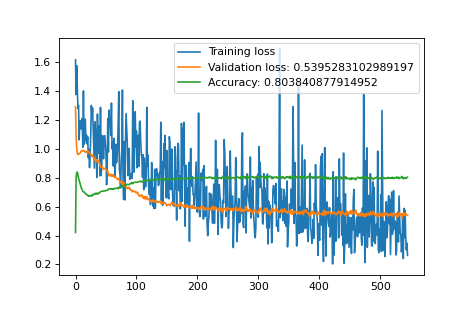

0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])
0
torch.Size([32, 1024])


KeyboardInterrupt: 

In [39]:
%matplotlib notebook
%matplotlib notebook
# defining the number of epochs
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []

accuracy_running = []


model = Net()
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=10**(-5) , weight_decay=0.0000)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
# training the model
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

n_epochs = 10000
for epoch in range(n_epochs):
#     optimizer = Adam(model.parameters(), lr=10**(-5 + (epoch/100)) , weight_decay=0.001)
#     optimizer = Adam(model.parameters(), lr=10**(-5 + (epoch/100)) , weight_decay=0.01)
    train(epoch)


In [64]:
input()

KeyboardInterrupt: Interrupted by user

<IPython.core.display.Javascript object>


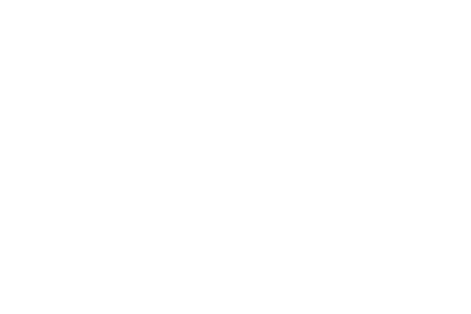

IndexError: tuple index out of range

In [40]:
layer_1 = model.state_dict()['cnn_layers.0.weight'].cpu()
layer_2 = model.state_dict()['cnn_layers.2.weight'].cpu()
layer_3 = model.state_dict()['cnn_layers.6.weight'].cpu()
# layer_4 = model.state_dict()['cnn_layers.11.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
# for ii in range(1):
#     for jj in range(6):
#         plt.subplot2grid((1,6),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-2,2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        #         im = plt.gca().get_images()
#         im.set_clim(0,1)
plt.figure()
for ii in range(layer_2.shape[1]):
    for jj in range(layer_2.shape[0]):
        plt.subplot2grid((layer_2.shape[1],layer_2.shape[0]),(ii,jj))
# for ii in range(12):
#     for jj in range(12):
#         plt.subplot2grid((12,12),(ii,jj))
        #         plt.imshow(layer_2[ii*jj + jj,0,:,:])
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.2,.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
# #         fig = plt.imshow(layer_3[jj*ii + jj,0,:,:], clim=(-.01,.01))
# #         fig.axes.get_xaxis().set_visible(False)
# #         fig.axes.get_yaxis().set_visible(False)
# plt.figure()
# for ii in range(layer_3.shape[1]):
#     for jj in range(layer_3.shape[0]):
#         plt.subplot2grid((layer_3.shape[1],layer_3.shape[0]),(ii,jj))
#         fig = plt.imshow(layer_3[jj, ii,:,:], clim=(-.4,.4))
        fig = plt.imshow(layer_3[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
        
        
        
        
# plt.figure()
# for ii in range(layer_4.shape[1]):
#     for jj in range(layer_4.shape[0]):
#         plt.subplot2grid((layer_4.shape[1],layer_4.shape[0]),(ii,jj))
#         fig = plt.imshow(layer_4[jj, ii,:,:], clim=(-.2,.2))
#         fig.axes.get_xaxis().set_visible(False)
#         fig.axes.get_yaxis().set_visible(False)
# # model.state_dict()['cnn_layers.1.weight'].shape

In [66]:
# layer_1 = model.state_dict()['cnn_layers.0.weight'].cpu()
# layer_2 = model.state_dict()['cnn_layers.3.weight'].cpu()[0,:,:,:]
# # layer_3 = model.state_dict()['cnn_layers.6.weight'].cpu()

# plt.figure()
# for ii in range(8):
#     for jj in range(8):
#         plt.subplot2grid((8,8),(ii,jj))
#         plt.imshow(layer_1[jj*ii + jj,0,:,:])
# plt.figure()
# for ii in range(4):
#     for jj in range(4):
#         plt.subplot2grid((4,4),(ii,jj))
# #         plt.imshow(layer_2[ii*jj + jj,0,:,:])
#         plt.imshow(layer_2[jj*ii + jj,:,:])

# # plt.figure()
# # for ii in range(1):
# #     for jj in range(layer_3.shape[0]):
# #         plt.subplot2grid((layer_3.shape[1],layer_3.shape[0]),(ii,jj))
# #         plt.imshow(layer_3[jj,0,:,:])
# # # model.state_dict()['cnn_layers.1.weight'].shape

In [67]:
# print(model.state_dict())
# model.state_dict()['cnn_layers.6.weight'].cpu().shape
layer_3.shape

torch.Size([16, 16, 5, 5])

<IPython.core.display.Javascript object>


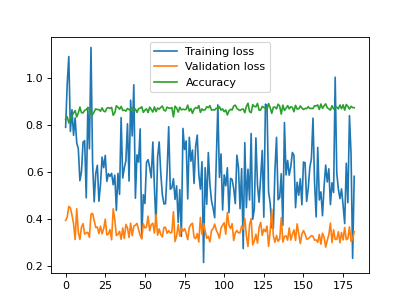

In [68]:
%matplotlib notebook
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss') 
plt.plot(accuracy_running, label='Accuracy')
plt.legend()
plt.show()


In [69]:
# if torch.cuda.is_available():
#     model = model.cuda()

# model.cpu()

# prediction for training set
# with torch.no_grad():
#     output = model(data_x.cuda())
# #     output = model(data_x)
output = model.cpu()(data_x.cpu())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.detach().numpy())
predictions = np.argmax(prob, axis=1)
# accuracy on training set
print(accuracy_score(data_y.cpu(), predictions))

repeats = 3
accuracy = np.zeros(repeats)
accuracy[accuracy==0] = np.nan
# prediction for validation set
for ii in range(repeats):
#     with torch.no_grad():
# #         output = model(val_x.cuda())
#         output = model(heldOut_x.cuda())
    output = model.cpu()(heldOut_x.cpu())
    
    softmax = torch.exp(output).cpu()
    prob = list(softmax.detach().numpy())
    predictions = np.argmax(prob, axis=1)

    # accuracy on validation set
    accuracy[ii] = accuracy_score(heldOut_y.cpu(), predictions)
print(np.mean(accuracy))
print(np.std(accuracy))

0.7687384615384616
0.8776863283036122
0.004828237787366898


<ipython-input-70-ca8586616f54>:14: RuntimeWarning: invalid value encountered in true_divide
  matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)


<IPython.core.display.Javascript object>


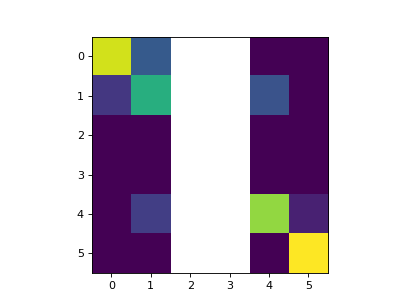

In [70]:
%matplotlib notebook
%matplotlib notebook

# val_y_bool = np.zeros((len(val_y) , np.max(val_y.numpy())-1))
heldOut_y_bool = np.zeros((len(heldOut_y) , 6))
predictions_bool = np.zeros((len(heldOut_y) , 6))
for ii in range(6):
    heldOut_y_bool[:,ii] = (heldOut_y.cpu().numpy() == ii)
    predictions_bool[:,ii] = (predictions==ii)
# plt.figure()
# plt.imshow(predictions_bool)

from numpy import matlib
matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)
plt.ion()
plt.figure()
plt.imshow(matrix_probability);
plt.show()

In [ ]:
input()

In [ ]:
plt.figure()
plt.plot(np.arange(10))
plt.plot(np.arange(4))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
plt.figure()
plt.imshow(output.cpu())

plt.figure()
plt.hist(predictions,15)
plt.hist(val_y,15);


In [ ]:
plt.figure()
plt.plot(predictions+1)
plt.plot(val_y+1)

In [ ]:
model.state_dict()['cnn_layers.0.weight'].cpu().reshape([24,4])

In [ ]:
%matplotlib qt
plt.figure()
plt.imshow(model.state_dict()['cnn_layers.0.weight'].cpu().reshape([24,4]))

In [ ]:
x = np.linspace(0, 10*np.pi, 100)
y = np.sin(x)

plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(x, y, 'b-')

for phase in np.linspace(0, 10*np.pi, 100):
    line1.set_ydata(np.sin(0.5 * x + phase))
    fig.canvas.draw()
    plt.pause(0.1)

In [ ]:
data_posthoc_test = images_aug
data_posthoc_test = data_posthoc_test / np.max(np.max(data_posthoc_test, axis=2) , axis=1)[:,None,None]
data_posthoc_test = data_posthoc_test[:,None,:,:]
data_posthoc_test = torch.tensor(data_posthoc_test).type('torch.FloatTensor')

data_posthoc_test.shape

In [ ]:
with torch.no_grad():
    output = model(data_posthoc_test.cuda())
#     output = model(val_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
labels_extrapolated = np.argmax(prob, axis=1)

# %matplotlib inline
plt.figure()
plt.hist(labels_extrapolated);

In [ ]:

num_ROI = data_posthoc_test.shape[0]


labels_posthoc = np.zeros(num_ROI)

In [ ]:
# %matplotlib qt
plt.figure()
# plt.imshow(spatial_footprints_crop[: , : , 0])
plt.pause(0.5) 
input_val = 0
iter_start = 440
num_ROI = images.shape[0]

while np.int8(input_val) < 7:
    for ii in np.where(labels_extrapolated ==0)[0]:
        if ii >= iter_start:
#             print(ii)

            plt.imshow(images[ii, : , :])
            plt.title(ii)
            plt.show(block=False)
            plt.pause(0.15) 

            input_val = input()

            if not input_val:
                continue
            if np.int8(input_val) >=7:
                break
            if input_val:
                labels_posthoc[ii] = np.int8(input_val)
            plt.pause(0.15) 
#             print(f'Num labeled: {ii}')
    

In [ ]:
# %matplotlib inline
plt.figure()
plt.plot(labels_posthoc)
plt.figure()
plt.hist(labels_posthoc[labels_posthoc > 0]);

In [ ]:
labels_posthoc_indOfCorrected_bool = labels_posthoc > 0
labels_posthoc_filledIn = copy.deepcopy(labels_extrapolated)
labels_posthoc_filledIn[labels_posthoc_indOfCorrected_bool] = labels_posthoc[labels_posthoc_indOfCorrected_bool] -1
plt.figure()
plt.plot(labels_posthoc_filledIn)
plt.figure()
plt.hist(labels_posthoc_filledIn,20);

In [ ]:
# np.save('labels_posthoc_filledIn.npy',labels_posthoc_filledIn)
# np.save('labels_posthoc.npy',labels_posthoc)

In [ ]:
# converting validation images into torch format
val_x = val_x[:,None,:,:]
# val_x  = torch.from_numpy(val_x).type('torch.FloatTensor')
val_x = torch.tensor(val_x).type('torch.FloatTensor')

# converting the target into torch format
val_y = val_y.astype(int);
# val_y = torch.from_numpy(val_y).type('torch.FloatTensor')
val_y = torch.tensor(val_y).type('torch.LongTensor')

# shape of validation data
val_x.shape, val_y.shape

In [ ]:
test = np.array(input())
# test.size
# test
if test:
    print(1)
else:
    print(0)

In [ ]:
with torch.no_grad():
    output = model(val_x.cuda())
#     output = model(val_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

In [ ]:


# shape of validation data
val_x.shape, val_y.shape

In [ ]:
labels_posthoc_backup = labels_posthoc

In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

In [71]:
# PATH = 
# torch.save(model.state_dict(), PATH)
torch.save(model.state_dict(), 'Net_trainedOnAug_20201006_trainingSet_mouse628_20200903and20200815_notGreat.pth')

In [ ]:
model = Net()
model.load_state_dict(torch.load('test_save.pth'))
model.eval()

In [ ]:
stat2 = np.load('./test data_ mouse2_5 _ 20200308/stat.npy' , allow_pickle=True)
stat2[0].keys()

In [42]:
data_x.shape

(9715, 36, 36)

In [44]:
images.shape
# labels.shape

images_flat = np.reshape(images , (images.shape[0] , images.shape[1]*images.shape[2]))

# tmp_images_aug = images_aug_noisy

# images_aug_flat = np.reshape(tmp_images_aug , (tmp_images_aug.shape[0] , tmp_images_aug.shape[1]*tmp_images_aug.shape[2]))
# images_aug_flat.shape

(4770, 1296)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 9715 samples in 1.027s...
[t-SNE] Computed neighbors for 9715 samples in 88.670s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9715
[t-SNE] Computed conditional probabilities for sample 2000 / 9715
[t-SNE] Computed conditional probabilities for sample 3000 / 9715
[t-SNE] Computed conditional probabilities for sample 4000 / 9715
[t-SNE] Computed conditional probabilities for sample 5000 / 9715
[t-SNE] Computed conditional probabilities for sample 6000 / 9715
[t-SNE] Computed conditional probabilities for sample 7000 / 9715
[t-SNE] Computed conditional probabilities for sample 8000 / 9715
[t-SNE] Computed conditional probabilities for sample 9000 / 9715
[t-SNE] Computed conditional probabilities for sample 9715 / 9715
[t-SNE] Mean sigma: 0.030153
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.779366
[t-SNE] KL divergence after 1000 iterations: 1.673902


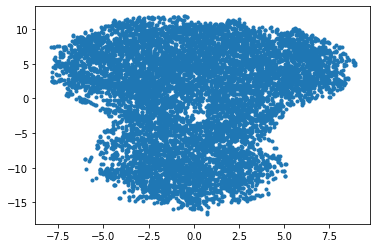

In [48]:
import sklearn.decomposition as decomp
import sklearn.manifold as manifold
X_embedded = manifold.TSNE(n_components=2 , perplexity=80 , verbose=1).fit_transform(images_flat)
plt.figure()
plt.plot(X_embedded[:,0] , X_embedded[:,1] , '.')

In [58]:
X_scores = decomp.PCA(n_components=5).fit_transform(images_flat)

<IPython.core.display.Javascript object>


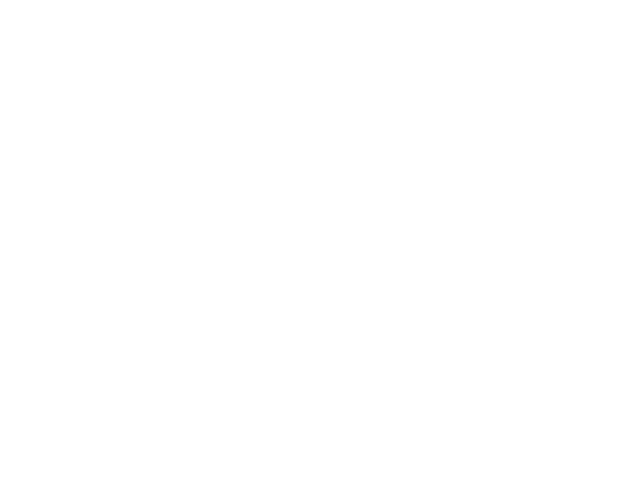

In [121]:
X_embedded2 = manifold.Isomap(n_neighbors=5, n_components=2).fit_transform(images_flat)
plt.figure()
plt.plot(X_embedded2[:,0] , X_embedded2[:,1] , '.')

<IPython.core.display.Javascript object>


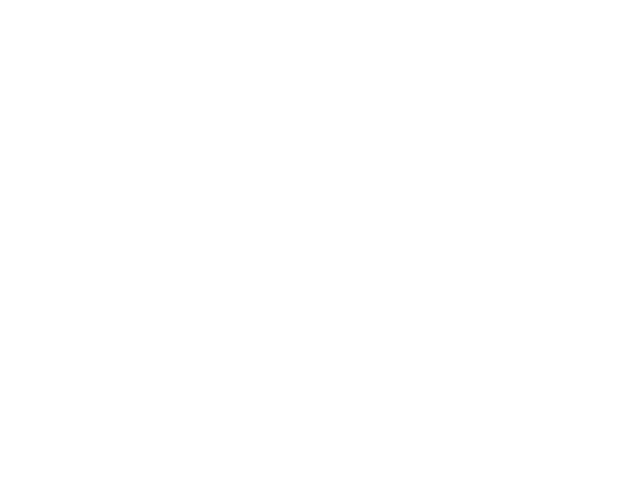

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2310 but corresponding boolean dimension is 9715

In [123]:
%matplotlib notebook

num_labels = 6
plt.figure()
for ii in range(num_labels):
    plt.plot(X_embedded[labels==ii,0] , X_embedded[labels==ii,1] , '.')

<IPython.core.display.Javascript object>


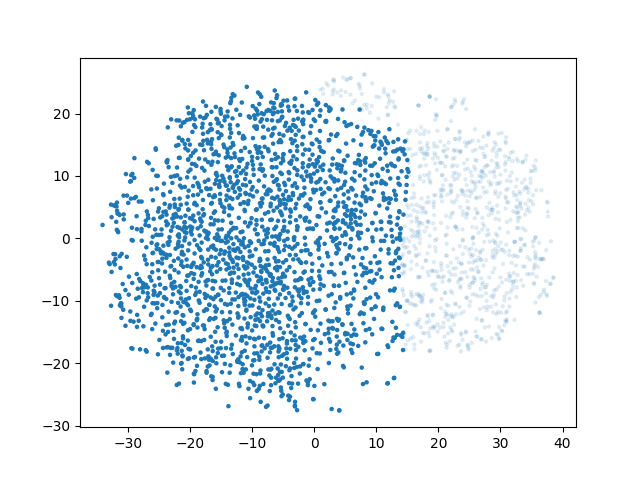

In [137]:
import numpy as np

from matplotlib.widgets import LassoSelector
from matplotlib.path import Path


class SelectFromCollection:
    """
    Select indices from a matplotlib collection using `LassoSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).

    Parameters
    ----------
    ax : `~matplotlib.axes.Axes`
        Axes to interact with.
    collection : `matplotlib.collections.Collection` subclass
        Collection you want to select from.
    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to *alpha_other*.
    """

    def __init__(self, ax, collection, alpha_other=0.1):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)

        # Ensure that we have separate colors for each object
        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))

        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

    def disconnect(self):
        self.lasso.disconnect_events()
        self.fc[:, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()


if __name__ == '__main__':
    import matplotlib.pyplot as plt

    # Fixing random state for reproducibility
    np.random.seed(19680801)

    data = np.random.rand(100, 2)

    subplot_kw = dict(xlim=(0, 1), ylim=(0, 1), autoscale_on=True)
    fig, ax = plt.subplots(subplot_kw=subplot_kw)

    pts = ax.scatter(X_embedded[:,0] , X_embedded[:,1] , s=5)

#     pts = ax.scatter(data[:, 0], data[:, 1], s=80)
    selector2 = SelectFromCollection(ax, pts)

    def accept(event):
        if event.key == "enter":
            print("Selected points:")
            print(selector.xys[selector.ind])
            selector.disconnect()
            ax.set_title("")
            fig.canvas.draw()

    fig.canvas.mpl_connect("key_press_event", accept)
    ax.set_title("Press enter to accept selected points.")

    plt.show()

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 2020 samples in 0.144s...
[t-SNE] Computed neighbors for 2020 samples in 7.801s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2020
[t-SNE] Computed conditional probabilities for sample 2000 / 2020
[t-SNE] Computed conditional probabilities for sample 2020 / 2020
[t-SNE] Mean sigma: 0.017486
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.290924
[t-SNE] KL divergence after 1000 iterations: 2.221849


<IPython.core.display.Javascript object>


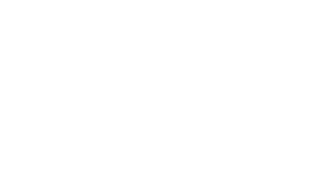

In [167]:
X_embedded3 = manifold.TSNE(n_components=2 , perplexity=35 , verbose=1).fit_transform(images_flat[selector1.ind,:][selector2.ind,:])
# X_embedded3 = manifold.MDS(n_components=2).fit_transform(images_flat[selector1.ind,:][selector2.ind,:])
# X_embedded3 = decomp.KernelPCA(n_components=2).fit_transform(images_flat[selector1.ind,:][selector2.ind,:])
plt.figure()
plt.plot(X_embedded3[:,0] , X_embedded3[:,1] , '.')

<IPython.core.display.Javascript object>


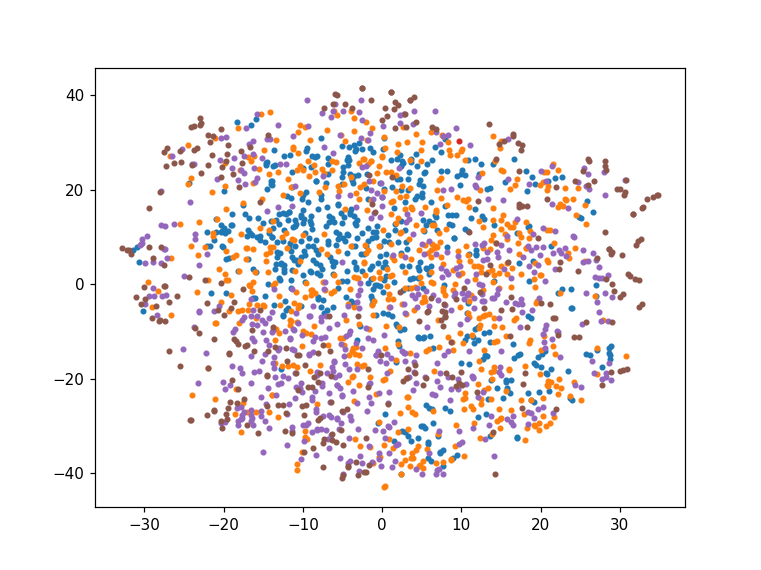

In [181]:
%matplotlib notebook

num_labels = 6
plt.figure()
for ii in range(num_labels):
    plt.plot(X_embedded3[((labels==ii)[selector1.ind])[selector2.ind],0] , X_embedded3[((labels==ii)[selector1.ind])[selector2.ind],1] , '.')

In [179]:
list_final = list(set(selector1.ind) & set(selector2.ind))

In [175]:
list_final

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

<ipython-input-203-42aaee2652e8>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


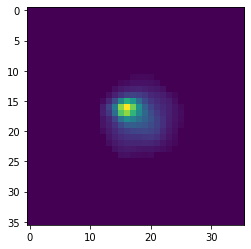

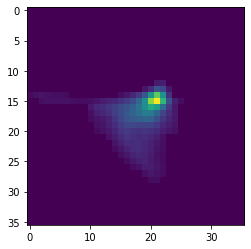

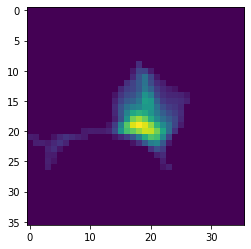

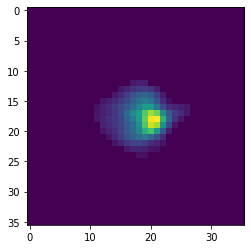

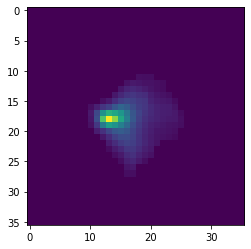

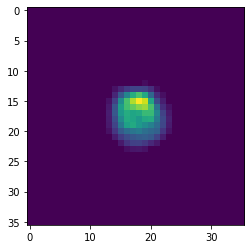

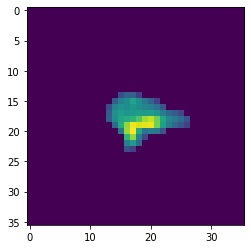

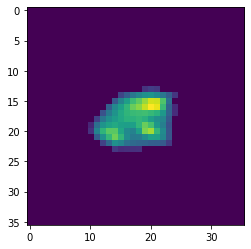

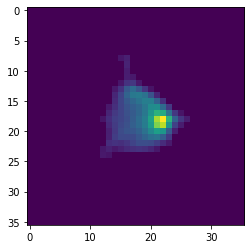

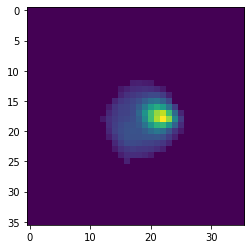

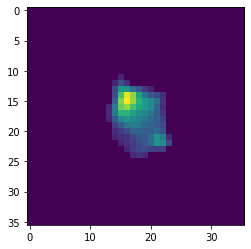

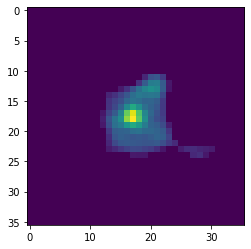

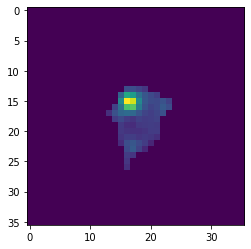

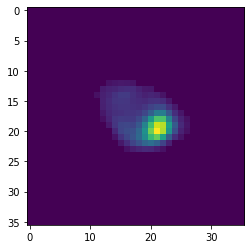

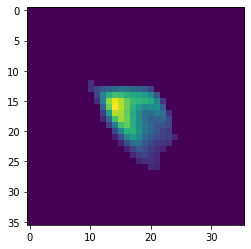

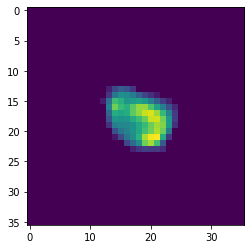

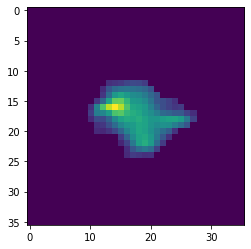

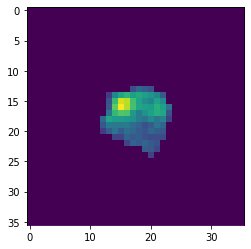

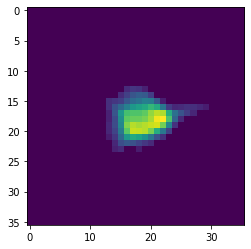

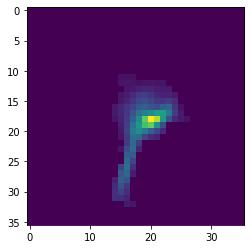

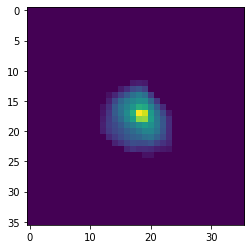

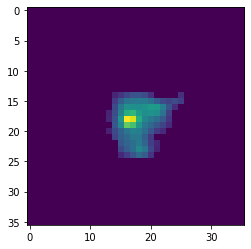

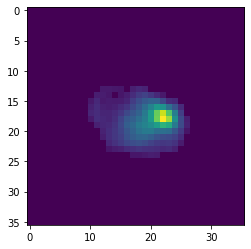

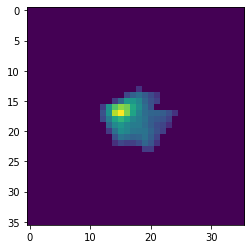

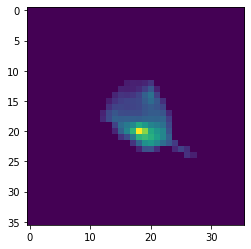

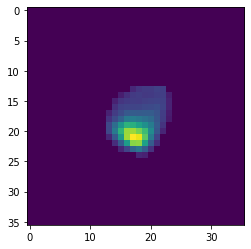

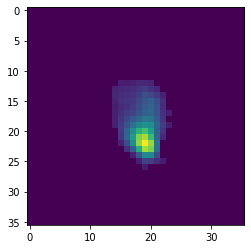

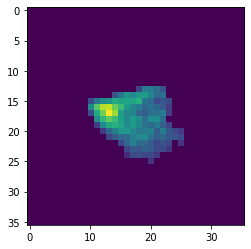

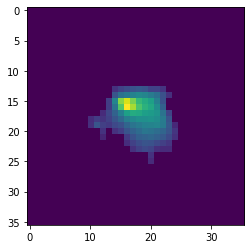

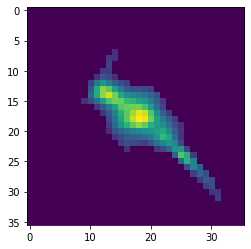

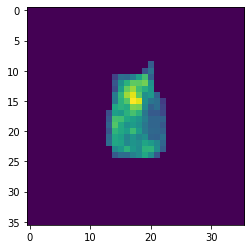

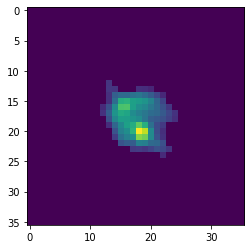

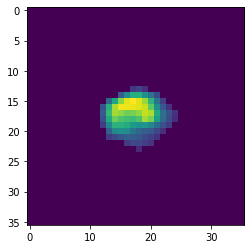

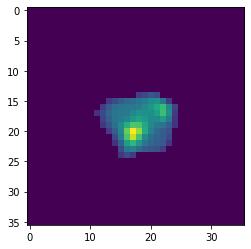

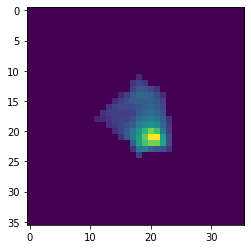

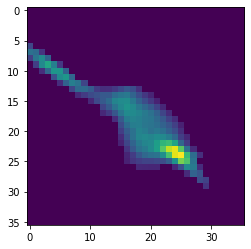

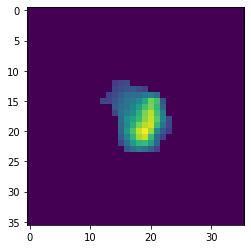

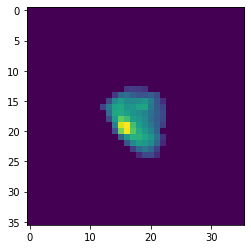

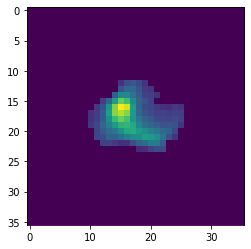

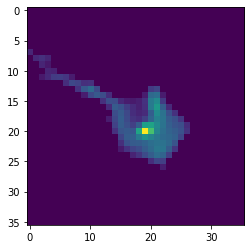

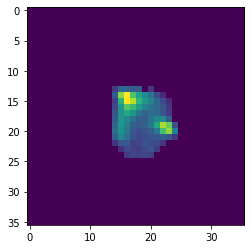

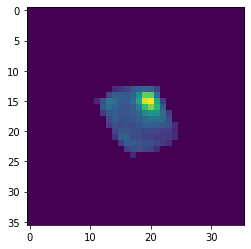

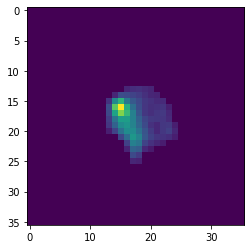

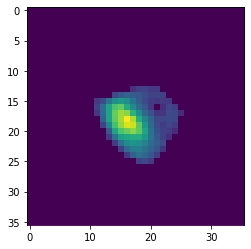

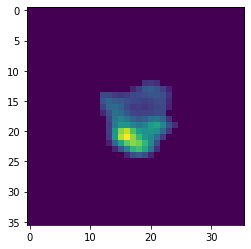

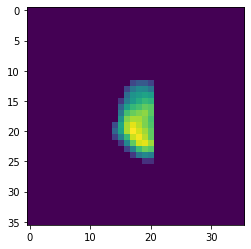

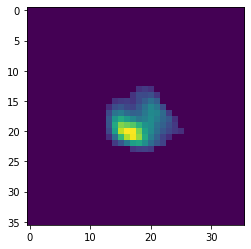

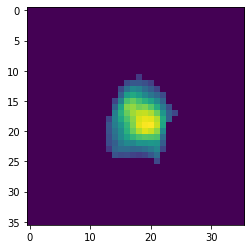

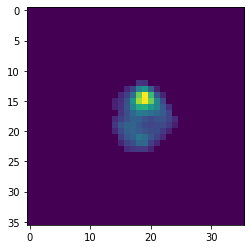

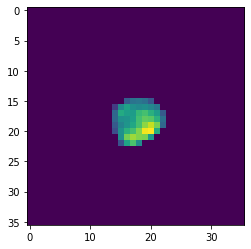

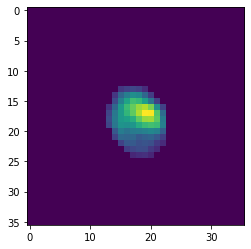

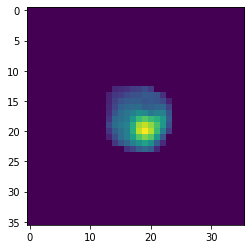

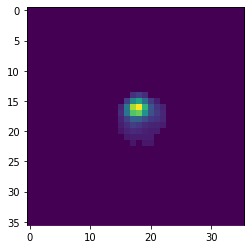

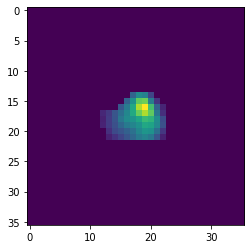

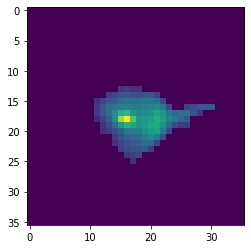

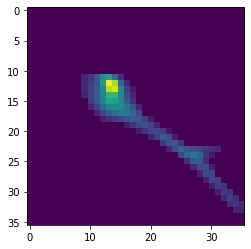

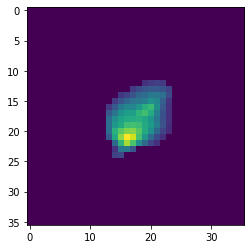

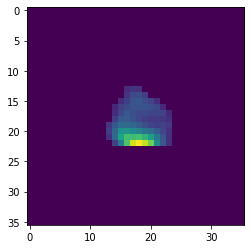

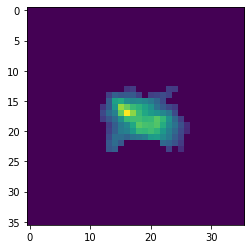

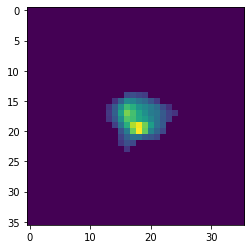

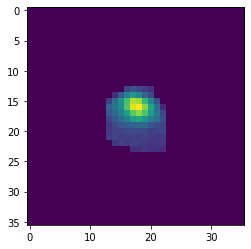

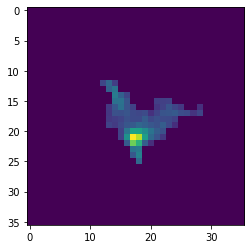

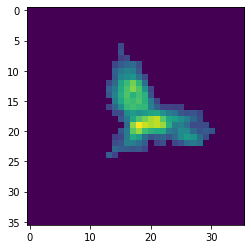

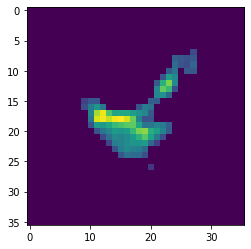

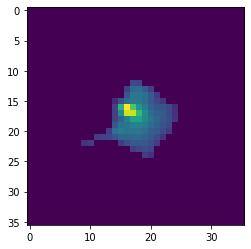

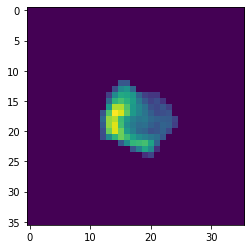

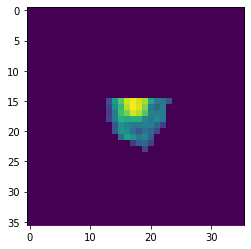

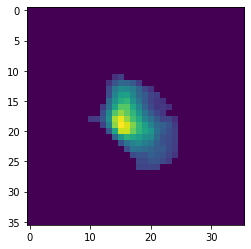

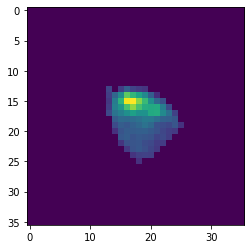

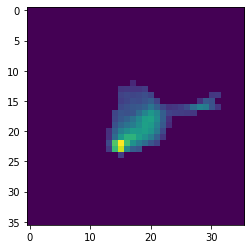

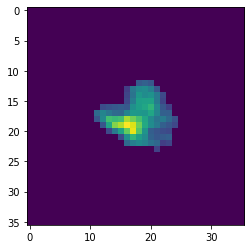

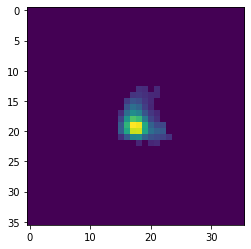

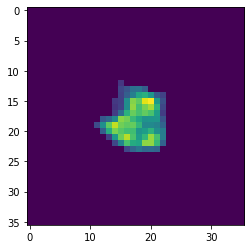

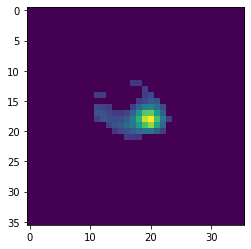

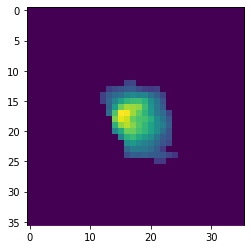

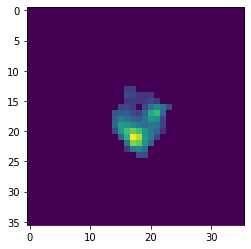

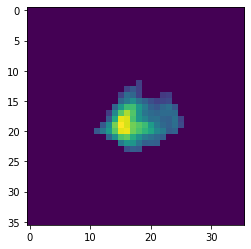

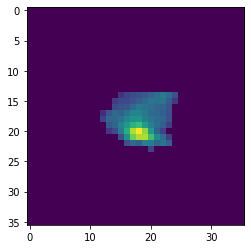

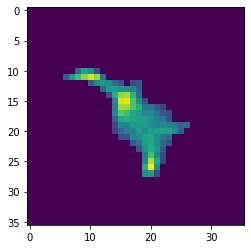

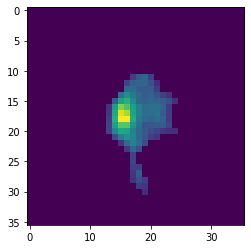

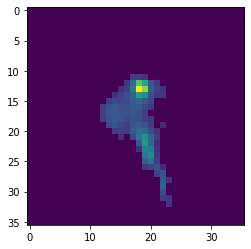

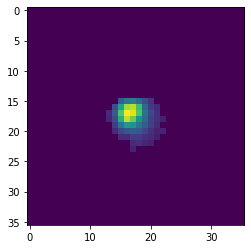

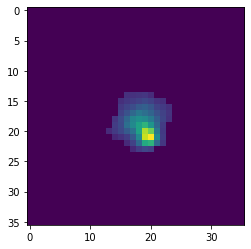

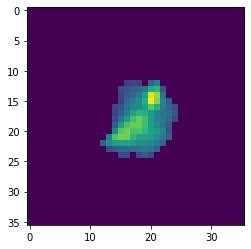

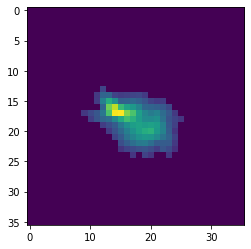

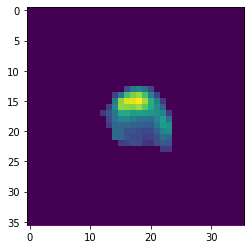

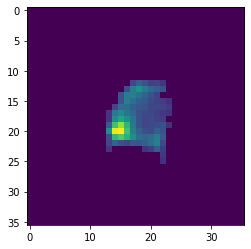

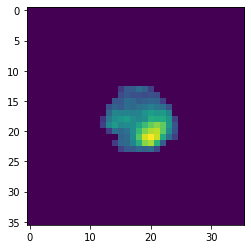

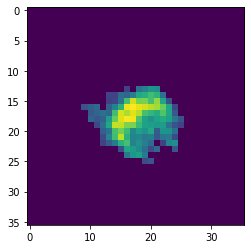

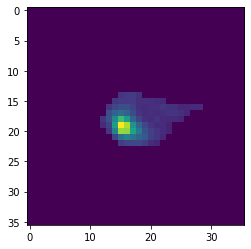

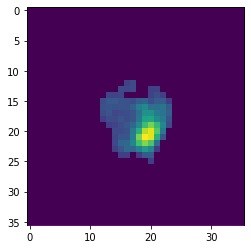

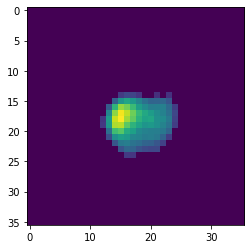

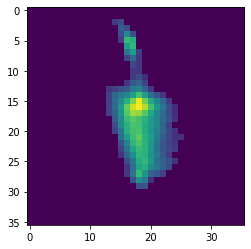

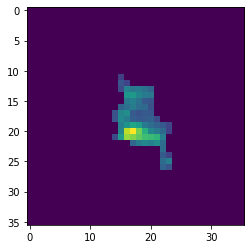

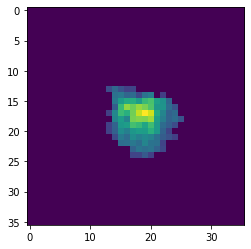

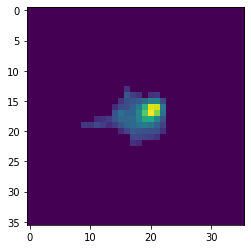

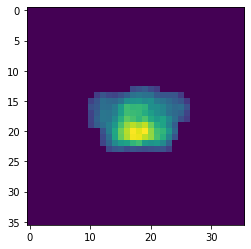

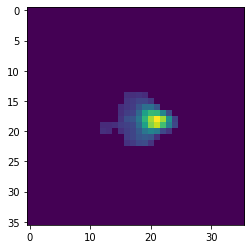

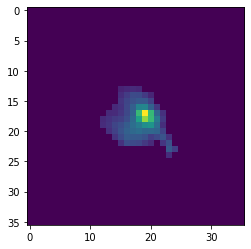

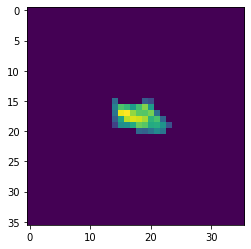

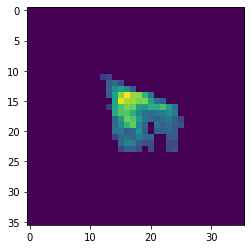

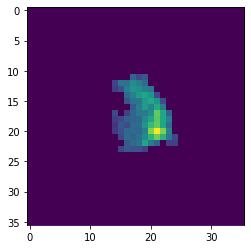

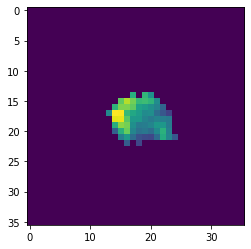

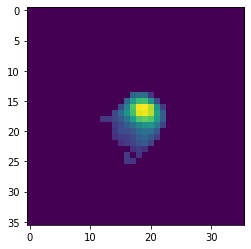

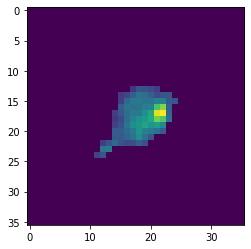

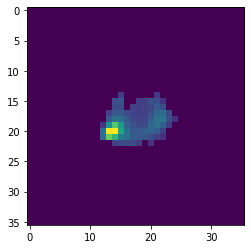

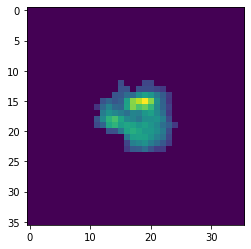

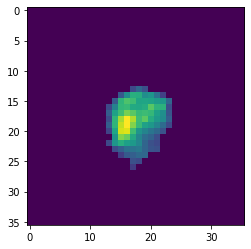

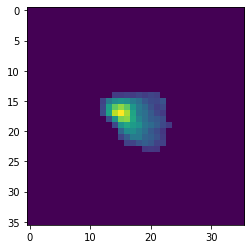

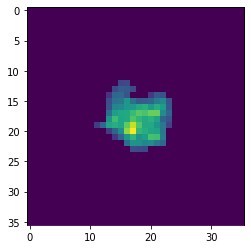

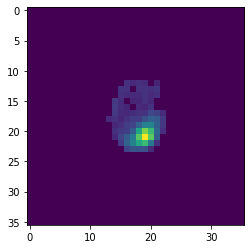

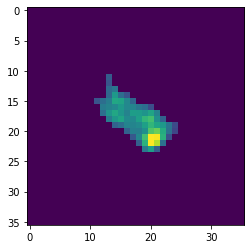

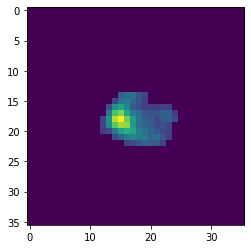

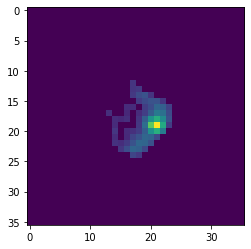

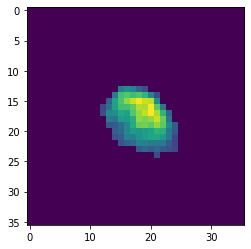

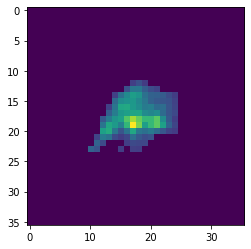

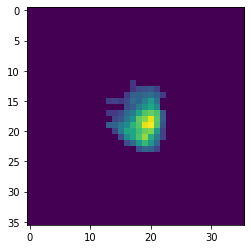

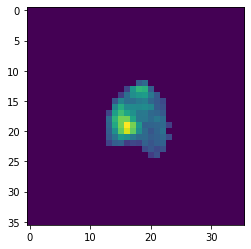

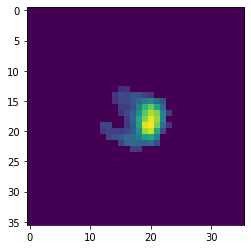

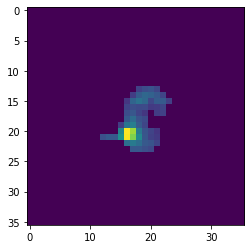

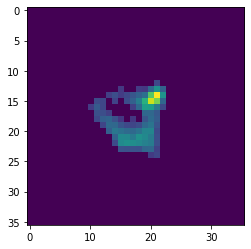

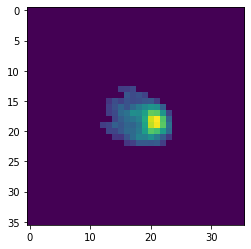

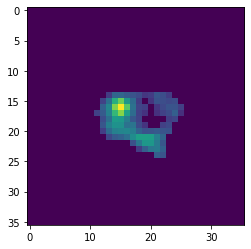

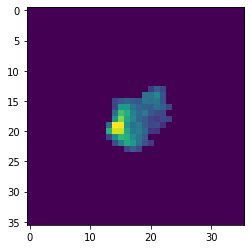

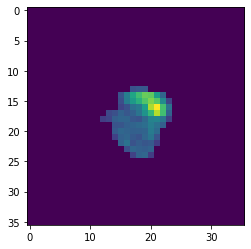

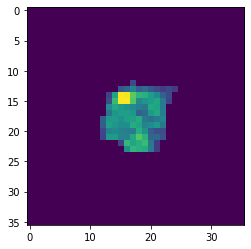

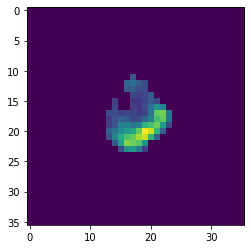

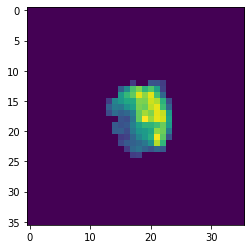

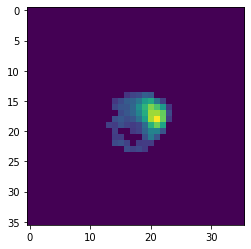

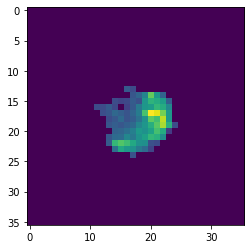

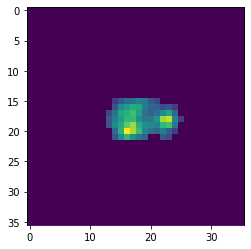

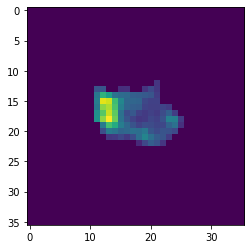

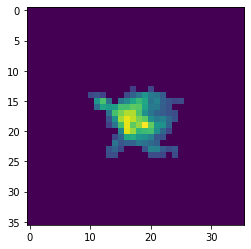

In [203]:
bad_labels = np.array(list_final)[np.where(labels[list_final] == 4)[0]]

%matplotlib inline
for ii in range(len(bad_labels)):
    plt.figure()
    plt.imshow(images[bad_labels[ii],:,:])

In [198]:
np.array(list_final)[np.where(labels[list_final] == 5)[0]]

array([2049, 2111, 2172,  132,  134, 2187,  156,  161,  173,  176,  180,
       2224,  190,  192,  195,  202,  203,  208, 2261,  218,  221,  223,
       2274,  231,  233, 2280,  241,  248,  251,  254,  258,  262,  265,
        273,  275,  276, 2323,  288,  292, 2343, 2344,  303,  304,  305,
        317,  318, 2376,  338,  341,  342,  343,  346,  348,  358,  367,
        368,  369,  375,  376,  385,  392,  393,  395,  403,  408, 2456,
        411,  414,  427, 2474, 2477,  432,  435,  436,  438, 2489,  450,
        454,  461, 2515,  470,  472,  475,  476, 2524, 2525,  485,  486,
        497,  499,  510,  520,  529, 2583,  536,  537, 2589,  549,  554,
       2617, 2622,  612, 2667, 2683, 2692,  652,  665,  666, 2722,  694,
        697, 2747,  700, 2755, 2767,  735, 2785,  757,  758,  763, 2818,
        783,  789,  791,  795,  803, 2865,  820, 2877,  832,  833,  864,
        870,  879,  880,  883,  885,  902,  906,  916,  940,  943,  944,
        962,  969,  990, 1023, 1030, 1063, 1071, 10